## Import libraries

In [1]:
import os
import csv
import random
from sklearn.model_selection import train_test_split
import numpy as np
from pyswarm import pso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import RandomUnderSampler
import warnings
import random
from functions import get_match_counts, locate_pattern, visualize_pattern
warnings.filterwarnings('ignore')

## Data preprocessing for MIT-BiH dataset

In [32]:
target_col = 'target'

In [3]:
X = data.iloc[:, :-1]
y = data.iloc[:,-1]
X

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,967,963,966,964,968,966,964,961,960,957,...,961,962,960,957,956,959,955,957,958,957
1,960,955,953,956,958,959,958,954,951,952,...,946,948,948,948,945,947,947,947,949,945
2,950,951,951,948,947,948,949,953,950,946,...,943,945,943,946,945,945,942,943,944,944
3,946,945,941,943,944,946,943,939,932,929,...,947,946,945,943,942,943,944,946,945,942
4,951,950,952,950,948,951,952,954,953,950,...,939,939,943,945,943,943,941,943,947,946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100049,975,972,972,971,971,971,973,973,971,968,...,974,970,962,960,956,956,956,954,951,951
100050,966,965,965,966,964,963,960,961,960,963,...,965,955,948,947,946,945,948,947,945,945
100051,960,960,959,958,955,954,950,952,953,952,...,961,952,945,941,939,940,938,939,941,945
100052,972,971,969,966,968,967,970,974,972,970,...,971,969,966,964,959,958,956,956,957,957


In [4]:
print(f'Target variable distribution: 0: {np.sum(y==0)}, 1: {np.sum(y==1)}, 2: {np.sum(y==2)}, 3: {np.sum(y==3)}, 4: {np.sum(y==4)}, ')

Target variable distribution: 0: 75045, 1: 8075, 2: 7259, 3: 2546, 4: 7129, 


## Visualize the different arrhythmias

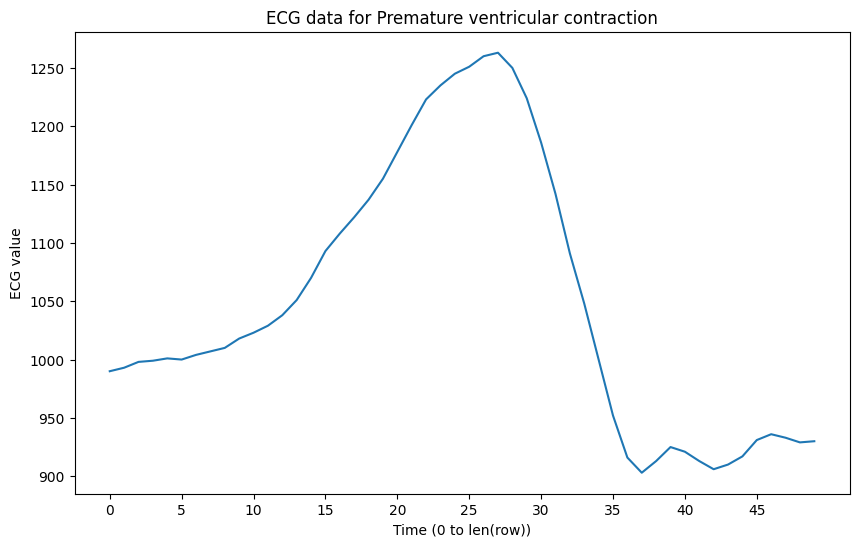

In [5]:
def visualize_row_by_value(df, value, figsize=(10, 6)):
    arrhythmia_types = {0: 'Normal beat', 1: 'Left bundle branch block beat', 2: 'Right bundle branch block beat', 3: 'Atrial premature beat', 4: 'Premature ventricular contraction'}
    filtered_df = df[df.iloc[:, -1] == value]
    plt.figure(figsize=figsize)
    selected_row = filtered_df.sample(n=1)
    plt.plot(range(len(selected_row.iloc[0, :-1])), selected_row.iloc[0, :-1].values, linestyle='-')
    plt.title(f'ECG data for {arrhythmia_types.get(value, "class " + str(value))}')
    plt.xlabel('Time (0 to len(row))')
    plt.ylabel('ECG value')
    plt.xticks(range(0, len(selected_row.iloc[0, :-1]), 5))  # Only show every 5th x tick
    plt.show()

visualize_row_by_value(data, 4)

## Train test split

In [8]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = undersampler.fit_resample(X, y)

df_res = pd.DataFrame(X_res, columns=X.columns)  
df_res[target_col] = y_res
num_class = len(np.unique(y_res))

desired_size_per_class = 2000

data = pd.concat([
    df_class.sample(n=desired_size_per_class, random_state=42)
    for _, df_class in df_res.groupby(target_col)
])
data

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
10120,963,961,960,958,957,954,956,957,958,957,...,941,940,944,944,941,937,932,937,939,0
97501,948,947,944,946,942,941,940,943,944,942,...,939,933,931,931,929,930,930,930,929,0
74223,956,959,959,961,961,962,961,964,966,966,...,925,937,953,964,969,966,969,968,972,0
84433,914,913,917,913,918,921,924,926,928,931,...,894,898,900,899,900,898,895,896,896,0
89585,1005,1006,1010,1013,1019,1024,1034,1042,1053,1064,...,982,987,991,990,985,982,981,977,975,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43299,1003,1009,1014,1017,1018,1020,1024,1026,1030,1031,...,868,883,904,919,932,937,943,951,960,4
80608,1031,1040,1043,1045,1043,1048,1053,1063,1080,1093,...,1083,1083,1082,1076,1072,1068,1073,1086,1101,4
87109,964,972,980,985,997,1019,1044,1068,1085,1100,...,921,918,915,905,902,898,894,892,894,4
42491,1052,1058,1064,1069,1069,1062,1065,1077,1103,1122,...,929,933,932,930,931,931,930,935,935,4


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], train_size=0.7)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

## Model parameters

In [10]:
params = {
    'max_depth': 3,
    'learning_rate': 0.05, 
    'n_estimators': 1000,
    'subsample': 0.5,
    'objective': 'multiclass',
    'verbosity': -1,
    'num_class': num_class
}

model = lgb.LGBMClassifier(**params)
callbacks = [lgb.early_stopping(stopping_rounds=10, verbose=False)]

## Functions

In [11]:
pattern_df_train = pd.DataFrame(y_train, columns=[target_col])
pattern_df_test = pd.DataFrame(y_test, columns=[target_col])



def objective_function(params):
    if 'experimental_pattern' not in pattern_df_train.columns:
        pattern_df_train['experimental_pattern'] = 0.0
    pattern_df_train.loc[:, 'experimental_pattern'] = get_match_counts(params, X_train).ravel()
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        pattern_df_train.drop([target_col], axis=1).values,
        pattern_df_train[target_col].values,
        test_size=0.15,
        random_state=42
    )
    model.fit(X_train_split, y_train_split,
             eval_set=[(X_val, y_val)],
             callbacks=callbacks)
    y_pred = model.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Define bounds for PSO
lb = [4, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] # width, start, end, stride, cct, pattern
ub = [8, len(X_train[0])-5, len(X_train[0]), 4, 1, 1, 1, 1, 1, 1, 1, 1, 1] # width, start, end, stride, cct, pattern

# Run PSO with increased swarmsize and reduced maxiter for faster convergence
optimal_params = []
for i in range(2):
    xopt, fopt = pso(objective_function, lb, ub, swarmsize=30, maxiter=5, debug=False)
    optimal_params.append(xopt)
    new_pattern_train = get_match_counts(xopt, X_train).flatten()
    new_pattern_test = get_match_counts(xopt, X_test).flatten()
    pattern_df_train = pd.concat([pattern_df_train, pd.Series(new_pattern_train, name=f'pattern_{i+1}')], axis=1)
    pattern_df_train.drop('experimental_pattern', axis=1, inplace=True)
    pattern_df_test = pd.concat([pattern_df_test, pd.Series(new_pattern_test, name=f'pattern_{i+1}')], axis=1)
    print("Optimal objective value:", fopt)

In [16]:
optimal_params

[array([ 7.60162124,  7.08010362, 50.        ,  1.1858108 ,  0.45309915,
         0.23079776,  0.48199196,  0.6767696 ,  0.35067054,  0.74367389,
         0.52217466,  0.58564457,  0.19591063]),
 array([ 7.03621504, 25.68116557, 42.08497796,  1.08815566,  0.2207512 ,
         0.45301393,  1.        ,  0.36165046,  0.86391351,  0.63374409,
         0.60551767,  0.43865237,  0.88464075])]

In [33]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    pattern_df_train.drop([target_col], axis=1).values,
    pattern_df_train[target_col].values,
    test_size=0.15,
    random_state=42
)
model.fit(X_train_split, y_train_split,
            eval_set=[(X_val, y_val)],
            callbacks=callbacks)
y_pred = model.predict(pattern_df_test.drop(target_col, axis=1))
accuracy = accuracy_score(y_pred, pattern_df_test[target_col])
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.53


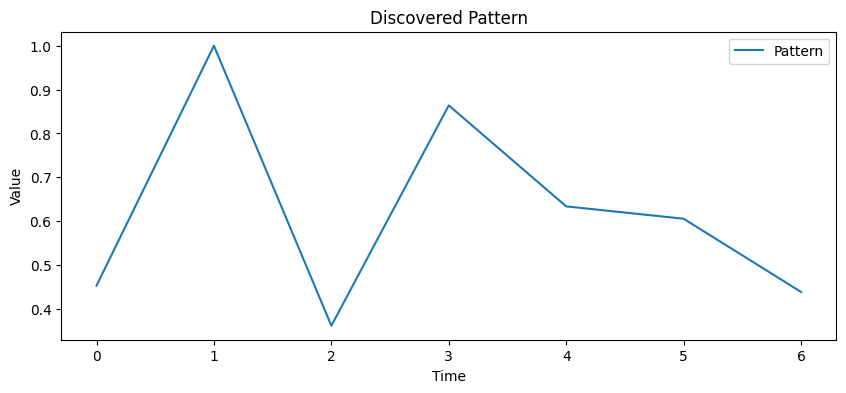

In [30]:
visualize_pattern(optimal_params[1])

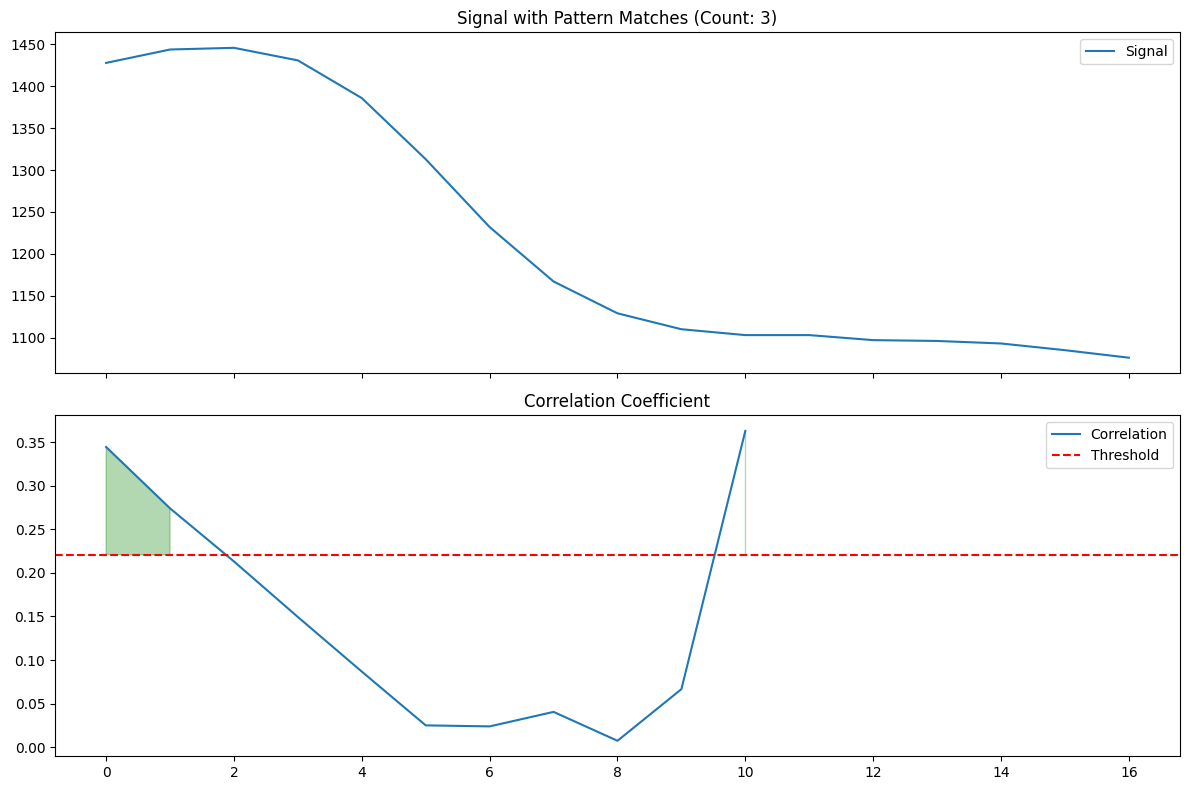

(array([ 0,  1, 10]),
 array([0.34438703, 0.27403341, 0.21310049, 0.1493796 , 0.08674559,
        0.02506479, 0.02388096, 0.04051911, 0.00737821, 0.06662184,
        0.36287408]))

In [31]:
locate_pattern(optimal_params[1], X_train, 0)